<center>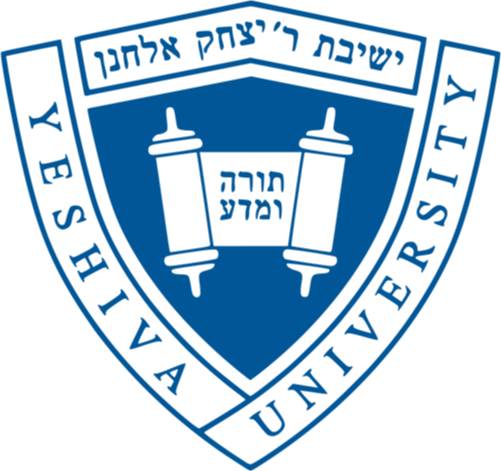</center>

<h1 style='text-align: center;'>Katz School of Science and Health</h1>
<h1 style='text-align: center;'>AIM 5007 Neural Networks and Deep Learning</h1>
<p>
<h2 style='text-align: center;'>Project 3</h1>
<br><br>

<h3 style='text-align: center;'>Radek Jan Holik</h3>
<br>
<br>

# Package import

In [1]:
# Import some important packages here
import os
import random
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR


from datetime import datetime, timedelta
from timeit import default_timer as timer

import warnings
warnings.filterwarnings("ignore")

# ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
if torch.cuda.is_available():
  print("CUDA available. Using GPU acceleration.")
  print(f"Number of CUDA devices : {torch.cuda.device_count()}")
  print(f"Device name : {torch.cuda.get_device_name(0)}")
  device = "cuda:0"
else:
  print("CUDA is NOT available. Using CPU for training.")
  device = "cpu"

CUDA available. Using GPU acceleration.
Number of CUDA devices : 1
Device name : NVIDIA GeForce RTX 3090


# 1. Build an image segmentation model using pytorch

In [3]:
class LungSegmentationModel(nn.Module):
    def __init__(self):
        super(LungSegmentationModel, self).__init__()

        # Encoder (ResNet-101)
        resnet = models.resnet101(pretrained = True)

        # Modifying the first layer of ResNet-101 to accept single-channel input
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3, bias = False)

        # Removing two last layers (average pooling and fully connected layer)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])

        # Separating the ResNet-101 layers into individual layers
        """
        ResNet101 layers into 4 main stages.
        Each stage consists of a set of bottleneck layers, and the number of bottleneck layers differs between stages.
        
        Here's the division of the ResNet101 layers into 4 stages:

            Stage1: layers 1 to 3 (first 3 bottleneck layers)
            Stage2: layers 4 to 9 (next 6 bottleneck layers)
            Stage3: layers 10 to 33 (next 24 bottleneck layers)
            Stage4: layers 34 to 50 (last 17 bottleneck layers)
        """
        self.encoder_conv1 = resnet.conv1
        self.encoder_bn1 = resnet.bn1
        self.encoder_relu = resnet.relu
        self.encoder_maxpool = resnet.maxpool
        self.encoder_stage1 = nn.Sequential(*list(resnet.layer1)[:3])  # First 3 layers of layer1
        self.encoder_stage2 = nn.Sequential(*list(resnet.layer1)[3:], *list(resnet.layer2)[:6])  # Last 3 layers of layer1 + first 6 layers of layer2
        self.encoder_stage3 = nn.Sequential(*list(resnet.layer2)[6:], *list(resnet.layer3))  # Last 2 layers of layer2 + all layers of layer3
        self.encoder_stage4 = resnet.layer4

        # Decoder
        self.decoder_block1 = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(1024),
        )

        self.decoder_block2 = nn.Sequential(
            nn.ConvTranspose2d(2048, 512, kernel_size=3, stride=2, padding=1, output_padding=1), # Changed input channels to 2048
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
        )

        self.decoder_block3 = nn.Sequential(
            nn.ConvTranspose2d(1024, 256, kernel_size=3, stride=2, padding=1, output_padding=1), # Changed input channels to 1024
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
        )

        self.decoder_block4 = nn.Sequential(
            nn.ConvTranspose2d(512, 128, kernel_size=3, stride=1, padding=1),  # Changed input channels to 512
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Conv2d(32, 1, kernel_size=1),
            nn.Sigmoid()
        )
        

    def forward(self, x):        
        # Encoder
        # Applying initial layers (conv1, bn1, relu, maxpool)
        x = self.encoder_conv1(x)
        x = self.encoder_bn1(x)
        x = self.encoder_relu(x)
        x = self.encoder_maxpool(x)

        # Applying the ResNet-101 layers
        x1 = self.encoder_stage1(x)  # Output after stage1
        x2 = self.encoder_stage2(x1)  # Output after stage2
        x3 = self.encoder_stage3(x2)  # Output after stage3
        x4 = self.encoder_stage4(x3)  # Output after stage4


        # Decoder
        dec1 = self.decoder_block1(x4)
        dec1 = torch.cat((dec1, x3), dim=1)  # Concatenating layer3 output with the decoder_block1 output
        
        dec2 = self.decoder_block2(dec1)
        dec2 = torch.cat((dec2, x2), dim=1)  # Concatenating layer2 output with the decoder_block2 output

        dec3 = self.decoder_block3(dec2)
        dec3 = torch.cat((dec3, x1), dim=1)  # Concatenating layer1 output with the decoder_block3 output

        dec4 = self.decoder_block4(dec3)  # Final output


        return dec4

In [4]:
image_size = (256, 256)

In [8]:
# Initialize the model

# Create the lung segmentation model
model = LungSegmentationModel().to(device)

print(model)

LungSegmentationModel(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

In [7]:
# Model Parameters
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} model parameters")

86,240,449 model parameters


In [8]:
print(f"Is my model in GPU? : {next(model.parameters()).is_cuda}\n")

# GPU memory cache size
if torch.cuda.is_available():
    print(f"The allocated memory in the GPU for the model : {torch.cuda.memory_allocated()/(1024 * 1024):.3f}MB")

Is my model in GPU? : True

The allocated memory in the GPU for the model : 331.208MB


In [9]:
# Model functionality test
# Load a sample image
image = torch.randn([1, 1, 256, 256]).to(device)

# Run the model on the image
with torch.no_grad():
    model.eval()
    output = model(image)

print(image.size())
del image

# Release GPU memory cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()

torch.Size([1, 1, 256, 256])


# 2. Train your model using [lung segmentation datasets](https://github.com/YoushanZhang/Lung_Segmentation)

#### __Dataset functions__

In [9]:
class ImageSegmentationDataset(Dataset):
    def __init__(self, images_folder, masks_folder, image_size = (256, 256), augmentation = False, normalize = False, mean = 0.2681, std = 0.2830):
        self.images_folder = images_folder
        self.masks_folder = masks_folder
        self.image_files = os.listdir(images_folder)
        self.image_size = image_size
        self.augmentation = augmentation
        self.normalize = normalize
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image_path = os.path.join(self.images_folder, self.image_files[index])
        mask_path = os.path.join(self.masks_folder, self.image_files[index])

        image = Image.open(image_path).convert("L")  # Load image as grayscale
        mask = Image.open(mask_path).convert("L")

        # =======================  Resizing =======================
        new_height, new_width = self.image_size

        image = transforms.Resize((new_height, new_width))(image)
        mask = transforms.Resize((new_height, new_width), interpolation = Image.NEAREST)(mask)

        if self.augmentation:
            # ======================= Random Rotation =======================
            angle = random.uniform(-15, 15)

            
            # Rotate the image and the mask
            image = transforms.functional.rotate(image, angle)
            mask = transforms.functional.rotate(mask, angle)

            # =======================  Random Horizontal Flip =======================
            flip_prob = random.random()

            if flip_prob < 0.35:
                image = transforms.functional.hflip(image)
                mask = transforms.functional.hflip(mask)

            # =============  Random Brightness and Contrast=============
            image = transforms.functional.adjust_brightness(image, brightness_factor = 0.1)
            image = transforms.functional.adjust_contrast(image, contrast_factor = 0.1)

        # Convert image and mask to tensor
        image = transforms.functional.to_tensor(image)
        mask = transforms.functional.to_tensor(mask)

        # Normalize image
        if self.normalize:
            image = transforms.functional.normalize(image, mean = [self.mean], std = [self.std])

        return image, mask

In [10]:
def calculate_mean_std(loader):
    mean = torch.zeros(1)
    std = torch.zeros(1)
    total_images = 0

    for images, _ in loader:
        total_images += images.size(0)
        mean += images.sum(dim=(0, 2, 3))
        std += (images ** 2).sum(dim=(0, 2, 3))

    mean /= total_images * images.size(2) * images.size(3)
    std /= total_images * images.size(2) * images.size(3)
    std = torch.sqrt(std - mean ** 2)

    return mean, std

## __Training data__

In [10]:
batch_size = 96

In [11]:
train_images = "./data/Train/Images/"
train_masks = "./data/Train/Masks/"

In [13]:
original_train_dataset = ImageSegmentationDataset(train_images, train_masks)
original_train_loader = train_dataloader = DataLoader(original_train_dataset, batch_size = batch_size, shuffle = True)
print(f"Number of training samples : {len(original_train_dataset)}")
print(f"Number of batches in train DataLoader: {len(original_train_loader)}")

Number of training samples : 800
Number of batches in train DataLoader: 9


In [14]:
train_dataset_1 = ImageSegmentationDataset(train_images, train_masks, image_size)
train_dataset_2 = ImageSegmentationDataset(train_images, train_masks, image_size, augmentation = True)
train_dataset = ConcatDataset([train_dataset_1, train_dataset_2])
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
print(f"Number of training samples : {len(train_dataset)}")
print(f"Number of batches in train DataLoader: {len(train_loader)}")

Number of training samples : 1600
Number of batches in train DataLoader: 17


In [21]:
# mean, std = calculate_mean_std(train_loader)
# print(f"Mean: {mean}, Std: {std}")

Mean: tensor([0.2681]), Std: tensor([0.2830])


In [12]:
mean, std = torch.tensor([0.2681]), torch.tensor([0.2830])
print(f"Mean: {mean}, Std: {std}")

Mean: tensor([0.2681]), Std: tensor([0.2830])


In [13]:
train_dataset_1 = ImageSegmentationDataset(train_images, train_masks, image_size, normalize = True, mean = mean, std = std)
train_dataset_2 = ImageSegmentationDataset(train_images, train_masks, image_size, augmentation = True, normalize = True, mean = mean, std = std)
train_dataset = ConcatDataset([train_dataset_1, train_dataset_2])
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

In [23]:
# norm_mean, norm_std = calculate_mean_std(train_loader)
# print(f"Mean: {norm_mean}, Std: {norm_std}")

Mean: tensor([0.0002]), Std: tensor([0.9999])


## __Test data__

In [14]:
test_images = "./data/Test/Images/"
test_masks = "./data/Test/Masks/"

In [15]:
test_dataset = ImageSegmentationDataset(test_images, test_masks, image_size, normalize = True, mean = mean, std = std)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)
print(f"Number of validation samples : {len(test_dataset)}")
print(f"Number of batches in validation DataLoader: {len(test_loader)}")

Number of validation samples : 200
Number of batches in validation DataLoader: 3


#### __Test the functionality of the model on the dataset__

In [16]:
def test_images(model, dataloader):
    print("\n=== The Start of the test. ===\n")

    model.eval()  # Set the model to evaluation mode

    for idx, (images, masks) in enumerate(dataloader):
        images = images.to(device)
        masks = masks.to(device)
        
        with torch.no_grad():
            try:
                pred_mask = model(images)
                print(f"Processed batch {idx + 1} successfully. Input images size : {images.size()}, pred_mask.size() : {pred_mask.size()}")
            except Exception as e:
                print(f"Error processing batch {idx + 1}: {e}")

    # Release GPU memory cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        
    print("\n=== The test was successful! ===")

In [17]:
# Test all the images in the training dataset
test_images(model, train_loader)


=== The Start of the test. ===

Processed batch 1 successfully. Input images size : torch.Size([96, 1, 256, 256]), pred_mask.size() : torch.Size([96, 1, 256, 256])
Processed batch 2 successfully. Input images size : torch.Size([96, 1, 256, 256]), pred_mask.size() : torch.Size([96, 1, 256, 256])
Processed batch 3 successfully. Input images size : torch.Size([96, 1, 256, 256]), pred_mask.size() : torch.Size([96, 1, 256, 256])
Processed batch 4 successfully. Input images size : torch.Size([96, 1, 256, 256]), pred_mask.size() : torch.Size([96, 1, 256, 256])
Processed batch 5 successfully. Input images size : torch.Size([96, 1, 256, 256]), pred_mask.size() : torch.Size([96, 1, 256, 256])
Processed batch 6 successfully. Input images size : torch.Size([96, 1, 256, 256]), pred_mask.size() : torch.Size([96, 1, 256, 256])
Processed batch 7 successfully. Input images size : torch.Size([96, 1, 256, 256]), pred_mask.size() : torch.Size([96, 1, 256, 256])
Processed batch 8 successfully. Input image

In [18]:
# Test all the images in the test dataset
test_images(model, test_loader)


=== The Start of the test. ===

Processed batch 1 successfully. Input images size : torch.Size([96, 1, 256, 256]), pred_mask.size() : torch.Size([96, 1, 256, 256])
Processed batch 2 successfully. Input images size : torch.Size([96, 1, 256, 256]), pred_mask.size() : torch.Size([96, 1, 256, 256])
Processed batch 3 successfully. Input images size : torch.Size([8, 1, 256, 256]), pred_mask.size() : torch.Size([8, 1, 256, 256])

=== The test was successful! ===


### __Plot lungs with thir masks__

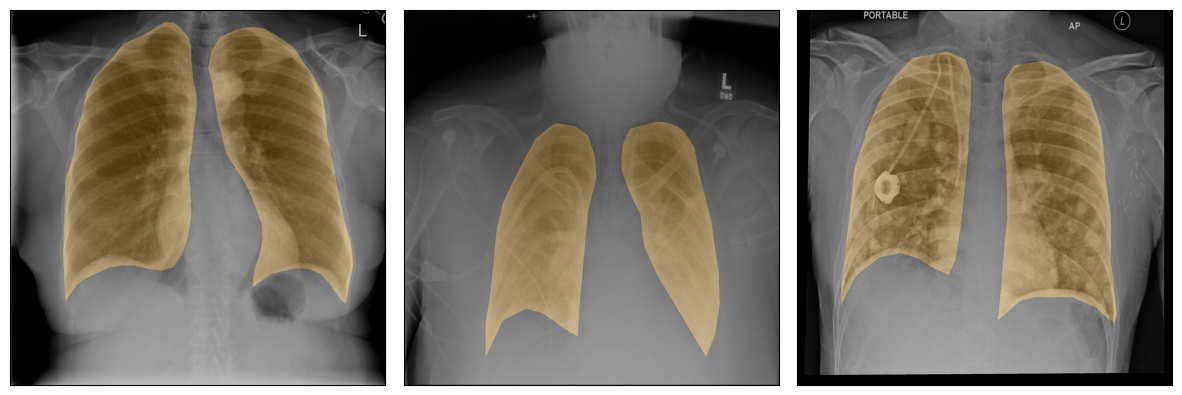

In [16]:
# Set the paths for the images and masks folders
images_folder = './data/train/images'
masks_folder = './data/train/masks'

# Get a list of all the image file names
image_files = os.listdir(images_folder)

# Randomly select 3 images from the list
random.seed(2)
selected_images = random.sample(image_files, 3)

# Create a figure and axes objects
fig, axs = plt.subplots(1, 3, figsize = (15, 5))

# Loop through the selected images and plot them with their corresponding masks
for i, image_name in enumerate(selected_images):
    # Load the image and mask
    image_path = os.path.join(images_folder, image_name)
    mask_path = os.path.join(masks_folder, image_name)
    image = Image.open(image_path).convert("RGB")
    mask = Image.open(mask_path)

    # Convert the mask to RGBA
    mask = mask.convert("RGBA")
    data = np.array(mask)
    r, g, b, a = data.T

    # Replace the white color (255, 255, 255) with orange (255, 165, 0)
    white_areas = (r == 255) & (g == 255) & (b == 255)
    data[..., :-1][white_areas.T] = (255, 165, 0)
    mask = Image.fromarray(data)

    # Apply alpha channel to the mask image
    alpha = 0.25
    a = Image.fromarray(a)
    a = a.point(lambda p: int(alpha * 255) if p > 0 else 0)
    mask.putalpha(a)

    # Overlay the mask on top of the image
    image.paste(mask, (0, 0), mask)

    # Plot the image with mask
    axs[i].imshow(image)

    # Remove the axis ticks and labels
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.subplots_adjust(wspace=0.05, hspace=0.15)
plt.show()

### __Training part__

In [16]:
# Pre-training preparation

# Release GPU memory cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [6]:
def save_model(model, optimizer, epoch):

    # Make a timestamp
    time_stamp = datetime.now().timestamp()
    year_time = datetime.fromtimestamp(time_stamp).strftime("%Y-%m-%d_%H-%M-%S")

    # Create a folder
    saved_models_folder = "./saved_models"

    if not os.path.exists(saved_models_folder):
        os.makedirs(saved_models_folder)

    # Save the model:
    model_scripted = torch.jit.script(model) # Export to TorchScript
    model_name = model.__class__.__name__
    model_scripted.save('./saved_models/' +  model_name + '_' + str(epoch) + '_' + year_time + '.pt')

    # Save the model's state_dict (weights):
    model_name = model.__class__.__name__
    model_state = model.state_dict()
    torch.save(model_state, './saved_models/' + model_name + '_' + str(epoch) + '_' + year_time + '_weights.pth')

    # Save the optimizer state:
    optimizer_state = optimizer.state_dict()
    torch.save(optimizer_state, './saved_models/' +  model_name + '_' + 'optimizer' + '_' + str(epoch) + '_' + year_time + '.pth')

def load_model(model_class, file_name_model, device):
    saved_models_folder = "./saved_models/"
    model_path = saved_models_folder + file_name_model

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model not found at '{model_path}'")

    model = model_class().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))

    return model

def load_optimizer(model, optimizer_class, optimizer_state_file, device):
    saved_models_folder = "./saved_models/"
    optimizer_state_path = saved_models_folder + optimizer_state_file

    if not os.path.exists(optimizer_state_path):
        raise FileNotFoundError(f"Optimizer state not found at '{optimizer_state_path}'")

    optimizer = optimizer_class(model.parameters())
    optimizer.load_state_dict(torch.load(optimizer_state_path, map_location=device))

    return optimizer

In [18]:
def saveList(myList, filename, epoch):

    # Make a timestamp
    time_stamp = datetime.now().timestamp()
    year_time = datetime.fromtimestamp(time_stamp).strftime("%Y-%m-%d_%H-%M-%S")

    # Create a csv folder
    saved_models_folder = "./my_lists/"

    if not os.path.exists(saved_models_folder):
        os.makedirs(saved_models_folder)

    # the filename should mention the extension 'npy'
    path = saved_models_folder +  str(filename) + '_' + epoch + '_' + year_time + '.npy'

    np.save(path, myList)
    # print("Saved successfully!")

def loadList(filename):

    # the filename should mention the extension 'npy'
    path = './my_lists/' + str(filename)

    # the filename should mention the extension 'npy'
    tempNumpyArray = np.load(path)
    return tempNumpyArray.tolist()

In [19]:
# Hyper-parameters
num_epochs = 100

learning_rate = 5e-6

# True for loading old model, False for a fresh model
load_lists_model = False

In [20]:
# Optimizer
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = learning_rate, weight_decay = 5e-4)

# Loss function
loss = nn.BCELoss()

# Scheduler 
scheduler = StepLR(optimizer, step_size = 10, gamma = 0.70)

In [21]:
if load_lists_model:
    loss_values_train = loadList("loss_values_train_50_2023-04-14_21-43-42.npy")
    loss_values_val = loadList("loss_values_val_50_2023-04-14_21-43-42.npy")
    iou_train = loadList("history_learning_rate_50_2023-04-14_21-43-42.npy")
    iou_val = loadList("history_learning_rate_50_2023-04-14_21-43-42.npy")
    dice_train = loadList("history_learning_rate_50_2023-04-14_21-43-42.npy")
    dice_val = loadList("history_learning_rate_50_2023-04-14_21-43-42.npy")

    history_learning_rate = loadList("history_learning_rate_50_2023-04-14_21-43-42.npy")

    print_messages = loadList("print_messages_50_2023-04-14_21-43-42.npy")
    
    current_epoch = len(loss_values_train)
    starting_epoch = current_epoch + 1
    print(f"Current epoch : {current_epoch}")
    print(f"Starting epoch : {starting_epoch}")

    # Load the model
    model = load_model("MyObjectDetector_50_2023-04-14_21-43-40.pt").to(device)

    # Model Parameters
    total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{total_trainable_params:,} model parameters")

    print(f"Is my model in GPU? : {next(model.parameters()).is_cuda}")

    # GPU memory cache size
    if torch.cuda.is_available():
        print(f"The allocated memory in the GPU for the model : {torch.cuda.memory_allocated()/(1024 * 1024):.3f}MB")

    # Load the optimizer state
    load_optimizer(optimizer, "MyObjectDetector_optimizer_50_2023-04-14_21-43-40.pth")
        
else:
    loss_values_train = []
    loss_values_val = []
    iou_train = []
    iou_val = []
    dice_train = []
    dice_val = []


    history_learning_rate = []

    print_messages = []
    current_epoch = 0
    starting_epoch = current_epoch + 1
    print(f"Current epoch : {current_epoch}")
    print(f"Starting epoch : {starting_epoch}")

Current epoch : 0
Starting epoch : 1


In [22]:
def update_plots(loss_values_train, loss_values_val, iou_values_train, iou_values_val, print_messages):
    clear_output(wait = True)

    # Display print messages
    for message in print_messages:
        print(message)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 6))

    # Plot loss values
    ax1.plot(range(1, len(loss_values_train) + 1), loss_values_train, label = "Train Loss")
    ax1.plot(range(1, len(loss_values_val) + 1), loss_values_val, label = "Validation Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.set_title("Loss values")
    ax1.grid(linestyle = "--", linewidth = 0.5)

    # Plot IoU values
    ax2.plot(range(1, len(iou_values_train) + 1), iou_values_train, label = "Train IoU")
    ax2.plot(range(1, len(iou_values_val) + 1), iou_values_val, label = "Validation IoU")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("IoU")
    ax2.legend()
    ax2.set_title("Intersection over Union (IoU) values")
    ax2.grid(linestyle = "--", linewidth = 0.5)

    plt.show()

In [23]:
def calculate_iou(pred, label):
    
    overlap = torch.logical_and(pred, label)
    union = torch.logical_or(pred, label)
    
    iou = torch.sum(overlap, dim = [-1,-2] ) / torch.sum(union, dim = [-1,-2] )
    
    return iou

def calculate_dice(pred, label):
    
    overlap = torch.logical_and(pred, label)
    denominator = torch.sum(pred, dim = [-1,-2] ) + torch.sum(label, dim = [-1,-2] )
    
    
    iou = torch.sum(overlap, dim = [-1,-2] ) / denominator
    
    return 2*iou

def evaluate_model(model, loader):
    model.eval()
    with torch.no_grad():
        iou_score = 0
        dice_score = 0
        num_samples = 0
        
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            
            # Get predicted masks
            pred_masks = model(images) > 0.5
            
            # Calculate IoU and Dice scores
            iou_score += torch.sum(calculate_iou(pred_masks, masks)).item()
            dice_score += torch.sum(calculate_dice(pred_masks, masks)).item()
            num_samples += images.size(0)
        
        iou_score /= num_samples
        dice_score /= num_samples
    
    return iou_score, dice_score


	 ****** Training has begun. ******

Initial learning rate : 5e-06
Epoch: 001, Train Loss: 0.6549819498, Validation Loss: 0.6618217031, Train IoU: 0.0000, Validation IoU: 0.0000, Train Dice: 0.0000, Validation Dice: 0.0000, Time: 16:53:25
Epoch: 002, Train Loss: 0.6313455315, Validation Loss: 0.6499303977, Train IoU: 0.0034, Validation IoU: 0.0013, Train Dice: 0.0068, Validation Dice: 0.0026, Time: 16:55:37
Epoch: 003, Train Loss: 0.5921073030, Validation Loss: 0.5810255806, Train IoU: 0.4323, Validation IoU: 0.4680, Train Dice: 0.5987, Validation Dice: 0.6311, Time: 16:57:39
Epoch: 004, Train Loss: 0.5470540979, Validation Loss: 0.5117691358, Train IoU: 0.5997, Validation IoU: 0.6536, Train Dice: 0.7450, Validation Dice: 0.7873, Time: 16:59:01
Epoch: 005, Train Loss: 0.5001883963, Validation Loss: 0.4645415445, Train IoU: 0.6828, Validation IoU: 0.7097, Train Dice: 0.8084, Validation Dice: 0.8277, Time: 17:00:34
Epoch: 006, Train Loss: 0.4522423271, Validation Loss: 0.4176097711, Tra

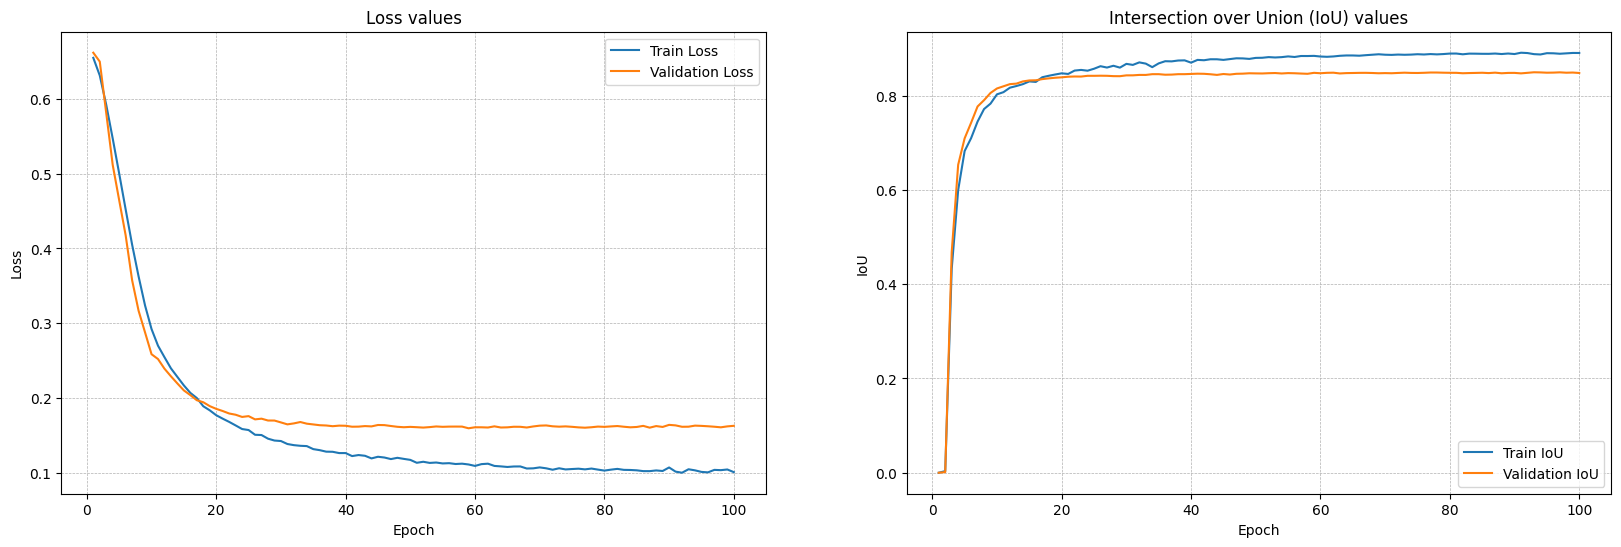

In [24]:
# Training process
start = timer()

message = '\n\t ****** Training has begun. ******\n'
print_messages.append(message)

message = f"Initial learning rate : {optimizer.param_groups[0]['lr']}"
print_messages.append(message)

# Update the plots
update_plots(loss_values_train, loss_values_val, iou_train, iou_val, print_messages)

for epoch in range(starting_epoch, num_epochs + 1):

    ########################## TRAINING ###############################
    # Set the network to training mode
    model.train()
    history_learning_rate.append(optimizer.param_groups[0]['lr'])

    train_loss = 0
    accumulated_IoU = 0
    accumulated_dice = 0


    # Iterate over the batches of training data
    for images, true_masks in train_loader:
      
        images, true_masks = images.to(device), true_masks.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Pass the images through the model (Forward pass)
        outputs = model(images)

        # Compute the loss based on the targets
        # print(true_masks.size())
        loss_train = loss(outputs, true_masks)

        # Accumulate loss
        train_loss += loss_train.item()

        # Backward pass and optimization
        loss_train.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0) # Gradient Clipping
        optimizer.step()

    # Add loss and IoU to history
    loss_values_train.append(train_loss / len(train_loader))
    iou_score, dice_score = evaluate_model(model, train_loader)
    iou_train.append(iou_score)
    dice_train.append(dice_score)


    ########################## VALIDATION ###############################
    # Set the network to testing validation
    model.eval()
    
    val_loss = 0
    accumulated_IoU = 0
    accumulated_dice = 0

    with torch.no_grad():
        for images, true_masks in test_loader:
            
            images, true_masks = images.to(device), true_masks.to(device)

            # Pass the images through the model (Forward pass)
            outputs = model(images)

            # Compute the loss based on the targets
            loss_val = loss(outputs, true_masks)

            # Accumulate loss
            val_loss += loss_val.item()

    # Add loss and IoU to history
    loss_values_val.append(val_loss / len(test_loader))
    iou_score, dice_score = evaluate_model(model, test_loader)
    iou_val.append(iou_score)
    dice_val.append(dice_score)


    # Scheduler of learning rate
    scheduler.step()

    # Print training statistics
    time_stamp = datetime.now().timestamp()
    current_time = datetime.fromtimestamp(time_stamp).strftime("%H:%M:%S")
    message = f"Epoch: {epoch:03}, Train Loss: {loss_values_train[-1]:.10f}, Validation Loss: {loss_values_val[-1]:.10f}, Train IoU: {iou_train[-1]:.4f}, Validation IoU: {iou_val[-1]:.4f}, Train Dice: {dice_train[-1]:.4f}, Validation Dice: {dice_val[-1]:.4f}, Time: {current_time}"
    print_messages.append(message)

    if epoch % 10 == 0:
        # Every 10th epoch, the learning rate is reduced to 70%
        new__learning_rate = optimizer.param_groups[0]['lr']

        message = f"New learning rate: {new__learning_rate}"
        print_messages.append(message)

    # Update the plots
    update_plots(loss_values_train, loss_values_val, iou_train, iou_val, print_messages)

    if (epoch % 50 == 0) or (iou_val[-1] >= 0.80):
        save_model(model, optimizer, str(epoch))
        saveList(loss_values_train,'loss_values_train', str(epoch))
        saveList(loss_values_val,'loss_values_val', str(epoch))
        saveList(iou_train,'iou_train', str(epoch))
        saveList(iou_val,'iou_val', str(epoch))

        saveList(history_learning_rate,'history_learning_rate', str(epoch))
        
        saveList(print_messages,'print_messages', str(epoch))

    


end = timer()
message = '\n\n\t ****** Training has finished. ******\n'
print_messages.append(message)
print(message)
message = f'\tTraining time: {timedelta(seconds=end-start)} [hh:mm:ss]'
print_messages.append(message)
print(message)

# Update the plots
update_plots(loss_values_train, loss_values_val, iou_train, iou_val, print_messages)

# Release GPU memory cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()

current_epoch = epoch
starting_epoch = current_epoch + 1
# print(f"Current epoch : {current_epoch}")
# print(f"Starting epoch : {starting_epoch}")


#### __Plot of the Loss and the Accuracy History__

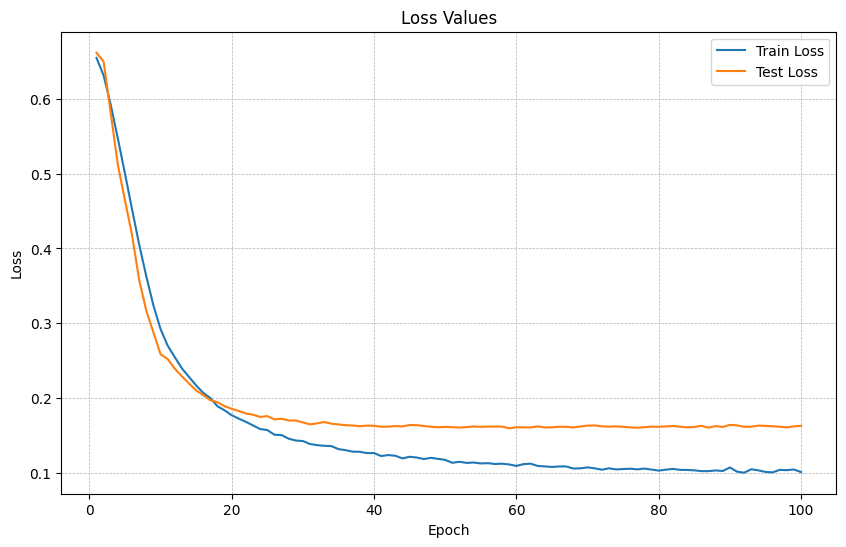

In [25]:
# Create the first plot for loss values
fig1, ax1 = plt.subplots(figsize = (10, 6))

ax1.plot(range(1, len(loss_values_train) + 1), loss_values_train, label = 'Train Loss')
ax1.plot(range(1, len(loss_values_val) + 1), loss_values_val, label = 'Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Loss Values')
ax1.grid(linestyle='--', linewidth=0.5)

plt.show()

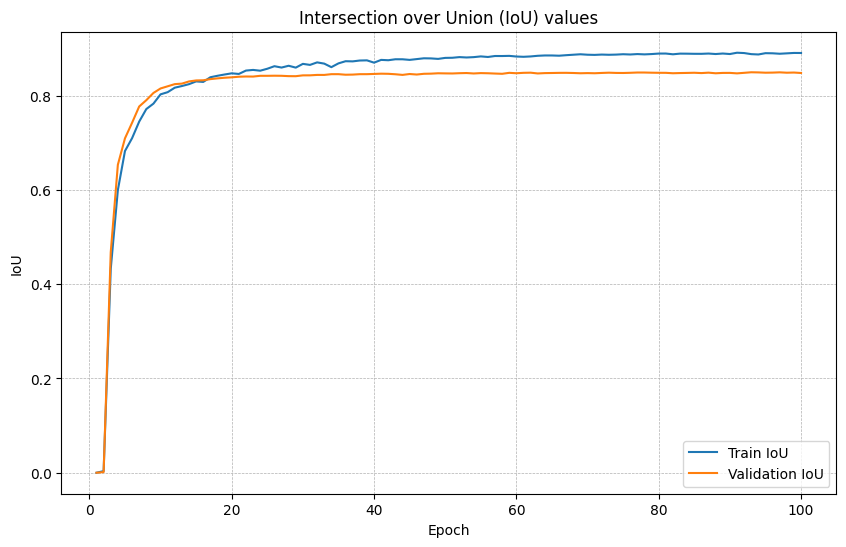

In [26]:
# Create the second plot for accuracy values
fig2, ax2 = plt.subplots(figsize = (10, 6))

ax2.plot(range(1, len(iou_train) + 1), iou_train, label = "Train IoU")
ax2.plot(range(1, len(iou_val) + 1), iou_val, label = "Validation IoU")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("IoU")
ax2.legend()
ax2.set_title("Intersection over Union (IoU) values")
ax2.grid(linestyle = "--", linewidth = 0.5)

plt.show()

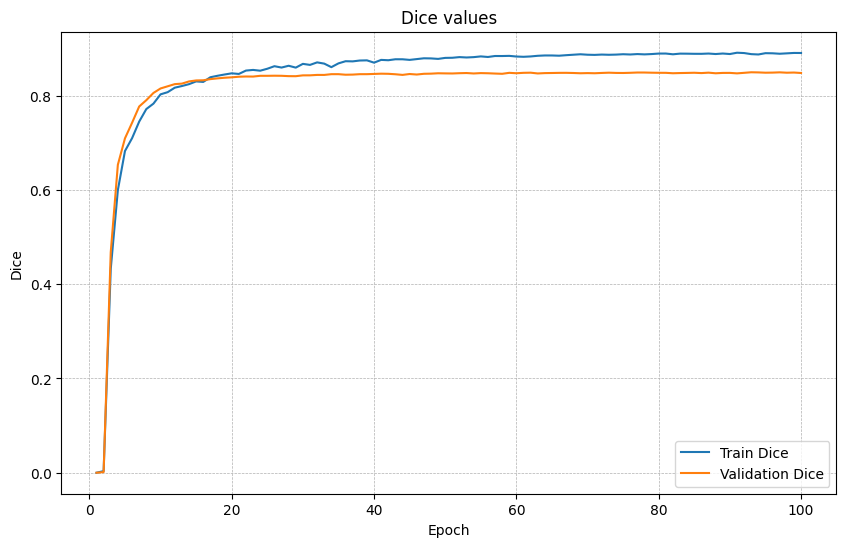

In [27]:
# Create the second plot for accuracy values
fig2, ax2 = plt.subplots(figsize = (10, 6))

ax2.plot(range(1, len(dice_train) + 1), iou_train, label = "Train Dice")
ax2.plot(range(1, len(dice_val) + 1), iou_val, label = "Validation Dice")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Dice")
ax2.legend()
ax2.set_title("Dice values")
ax2.grid(linestyle = "--", linewidth = 0.5)

plt.show()

#### __History of the Learning Rate__

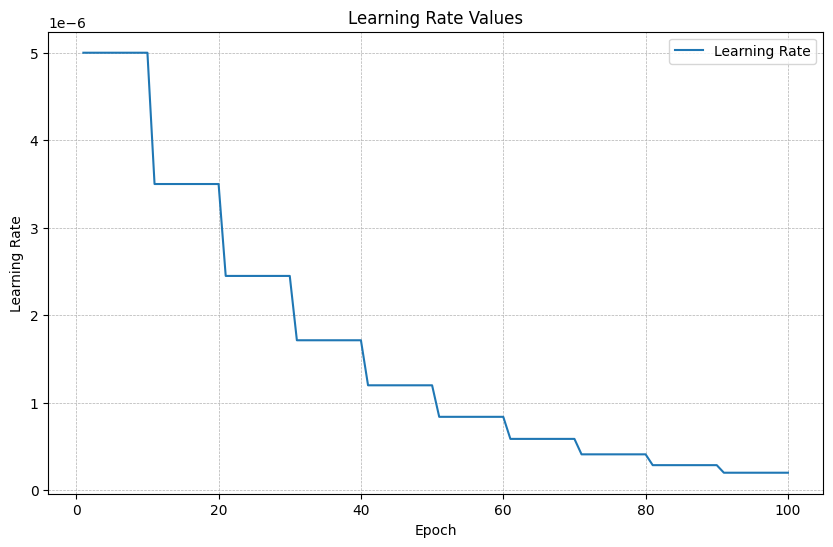

In [28]:
# Plot learning rate values
plt.figure(figsize = (10, 6))
plt.plot(range(1, len(history_learning_rate) + 1), history_learning_rate, label = 'Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.title('Learning Rate Values')
plt.grid(linestyle = '--', linewidth = 0.5)

plt.show()

# 3. Evaluate your model using the test images

In [29]:
def plot_lung_and_masks(lung_image, true_mask, predicted_mask):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))

    ax1.imshow(lung_image, cmap = 'gray')
    ax1.set_title('Lung Image')
    ax1.axis('off')

    ax2.imshow(true_mask, cmap = 'gray')
    ax2.set_title('True Mask')
    ax2.axis('off')

    ax3.imshow(predicted_mask, cmap = 'gray')
    ax3.set_title('Predicted Mask')
    ax3.axis('off')

    plt.subplots_adjust(wspace = 0.05, hspace = 0.15)
    plt.show()

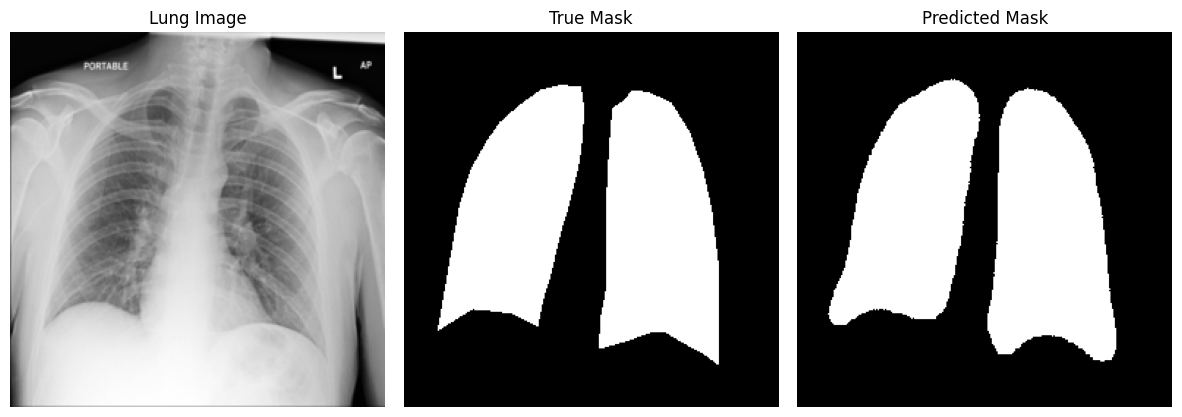

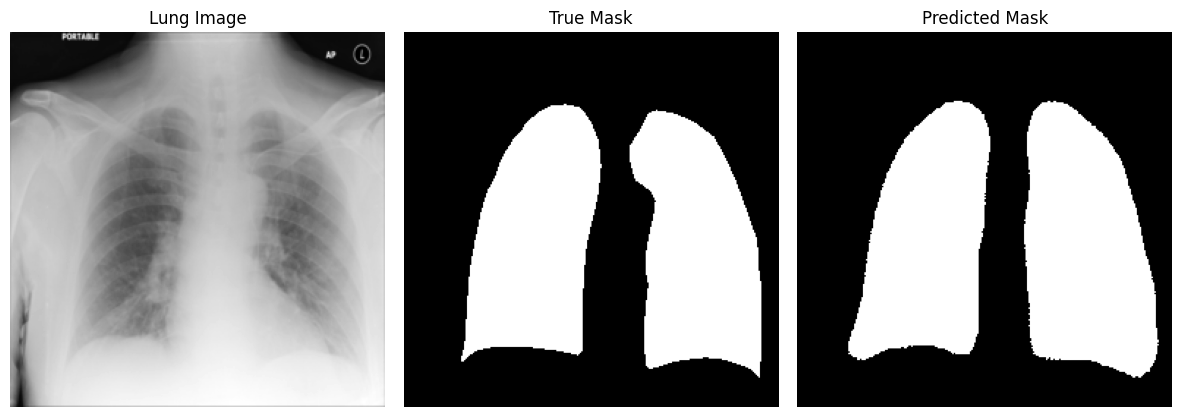

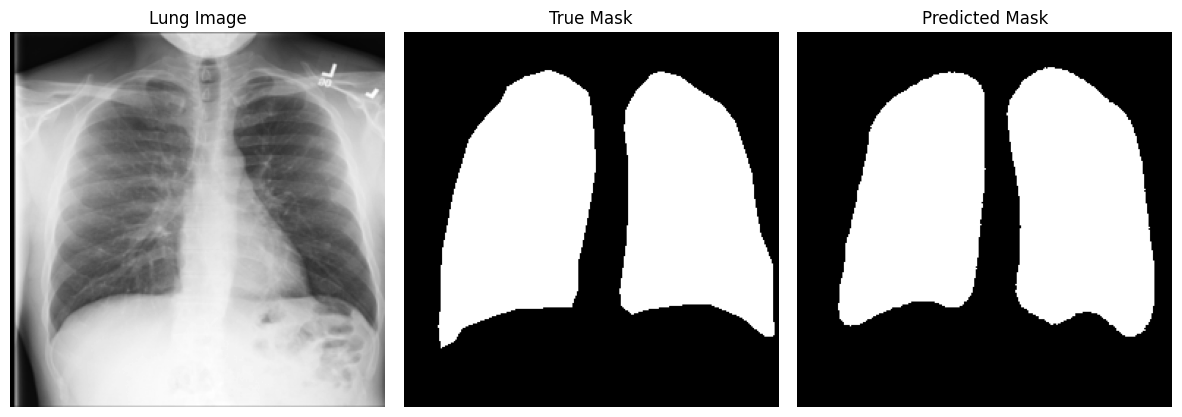

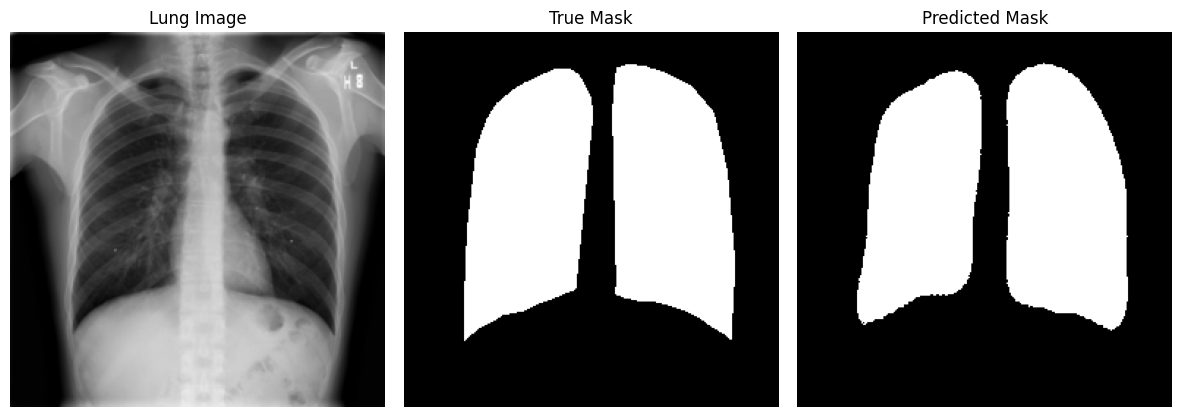

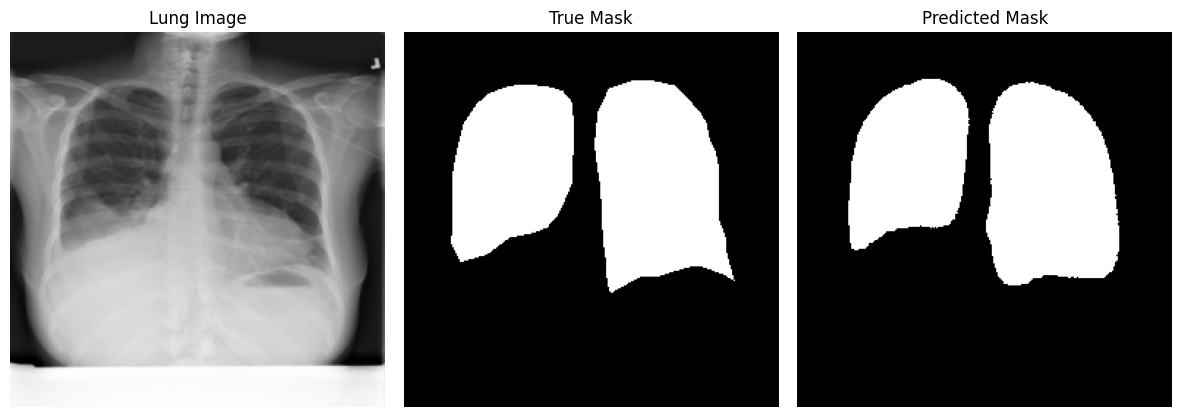

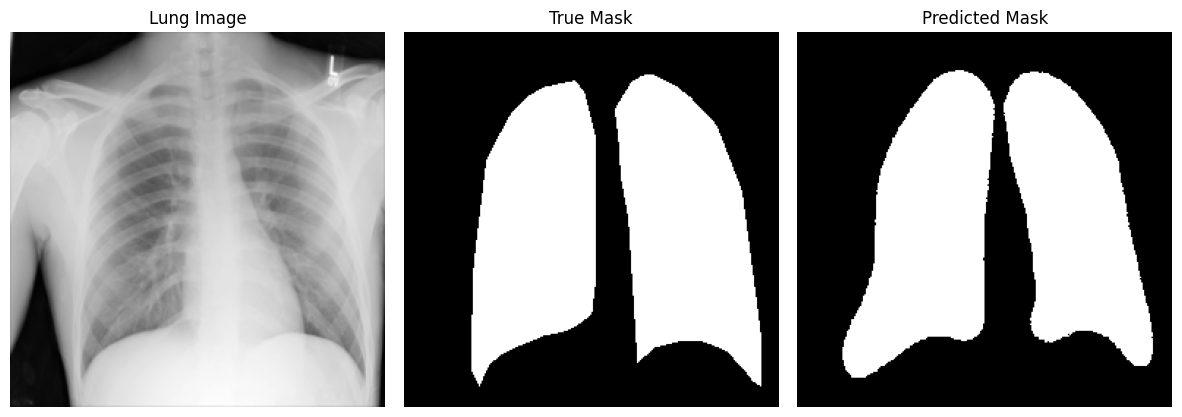

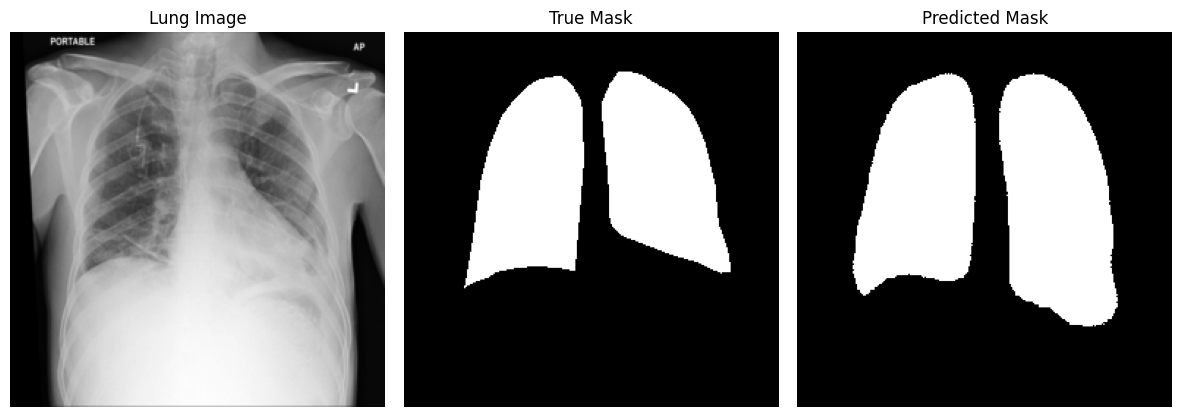

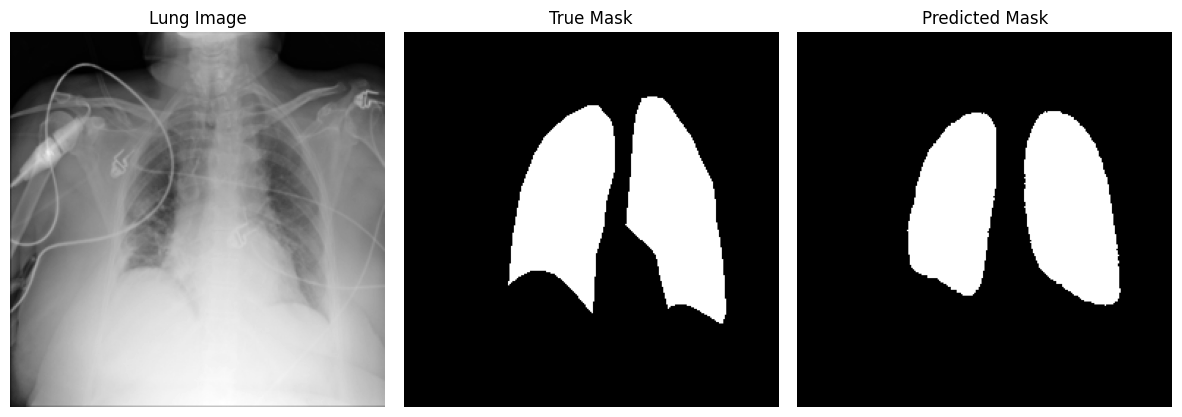

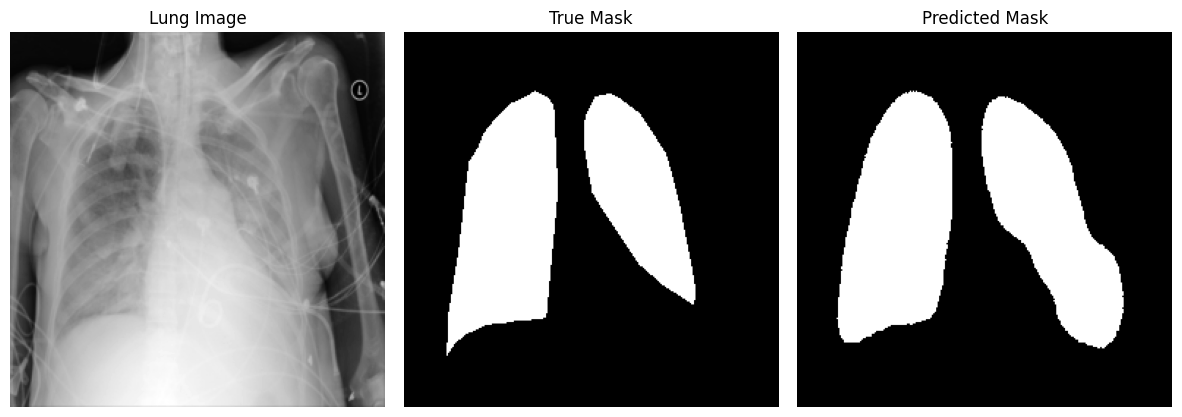

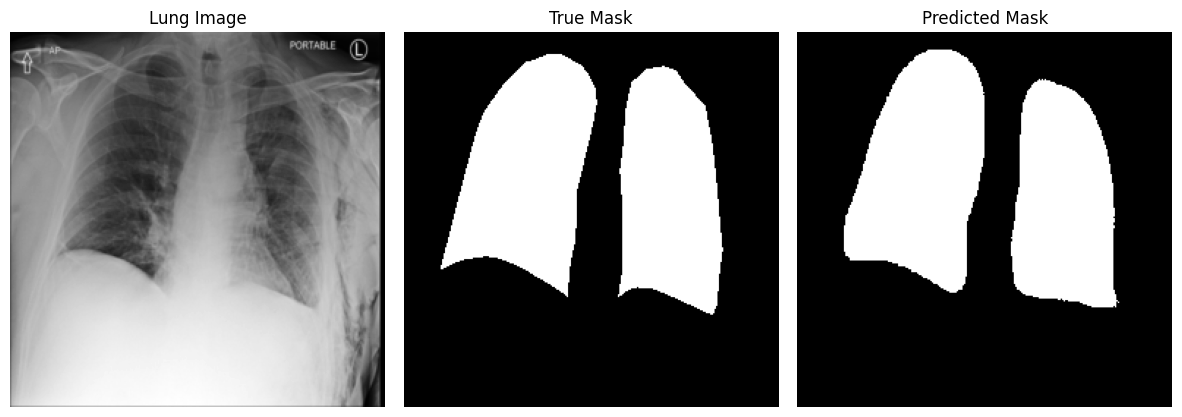

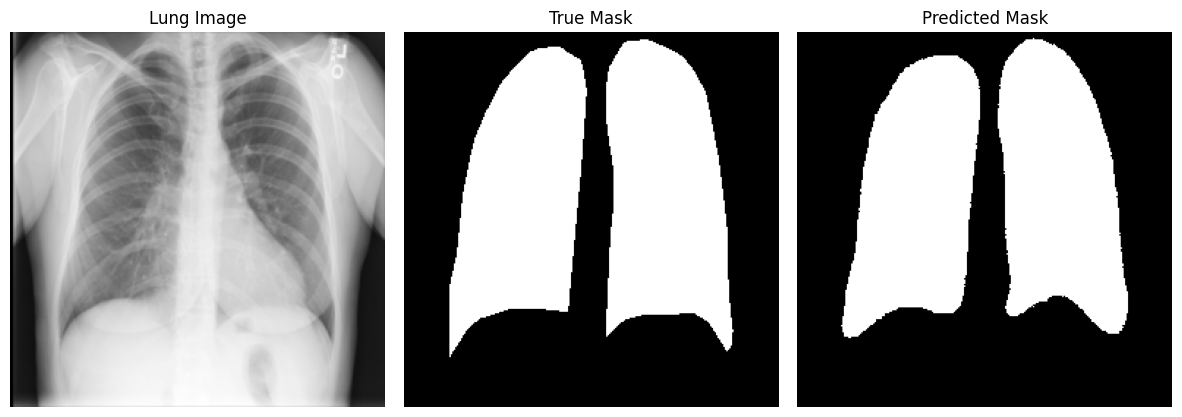

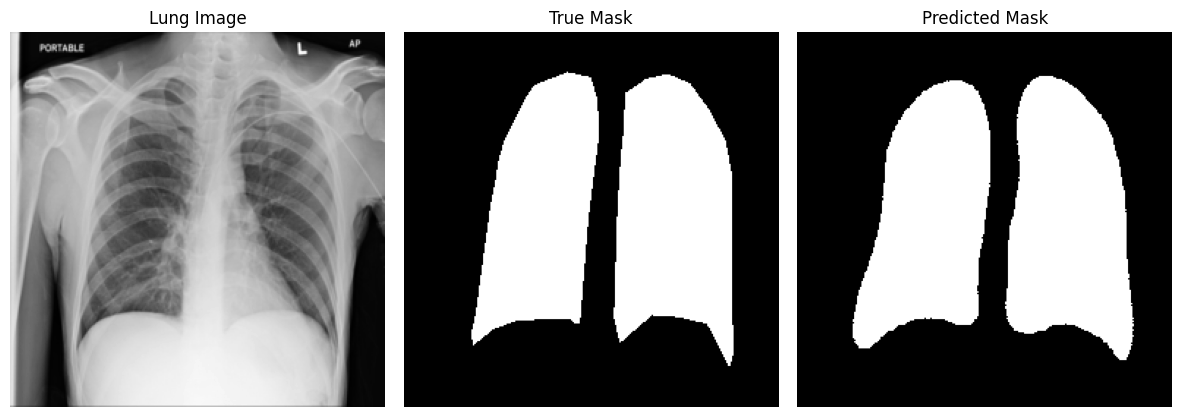

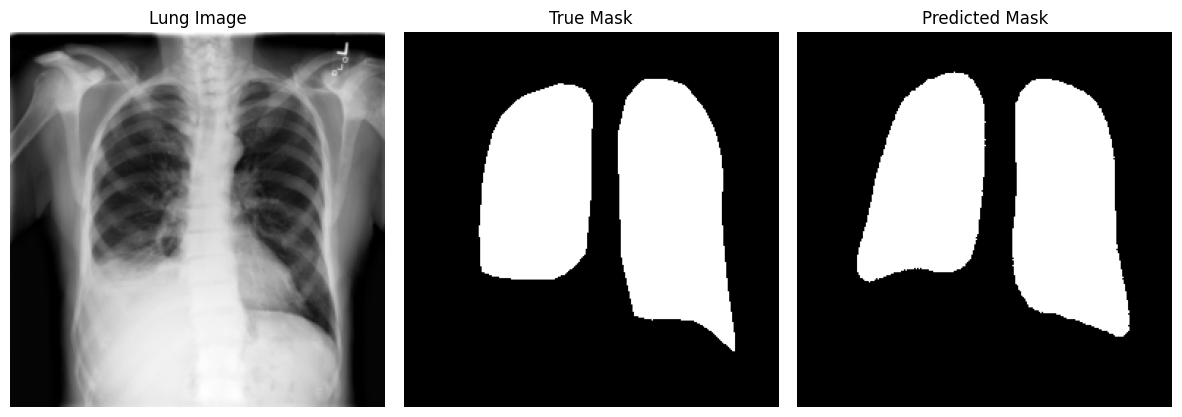

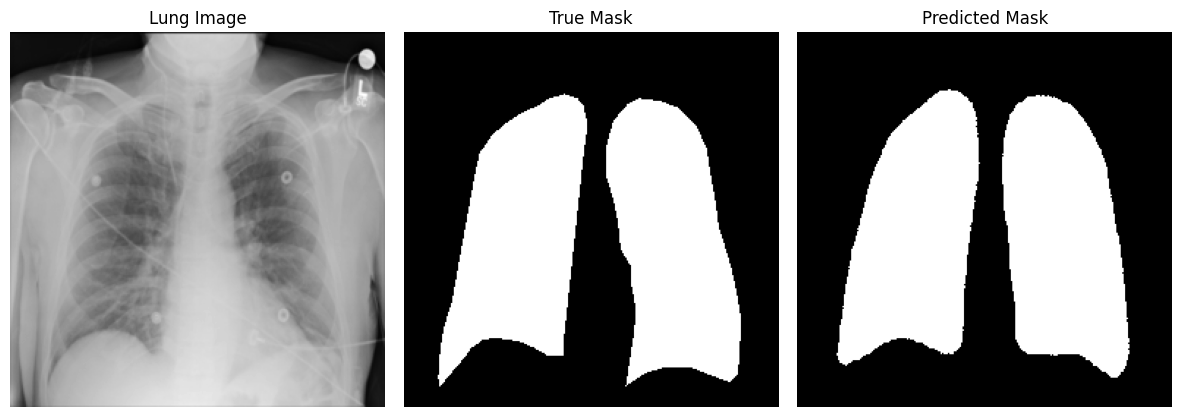

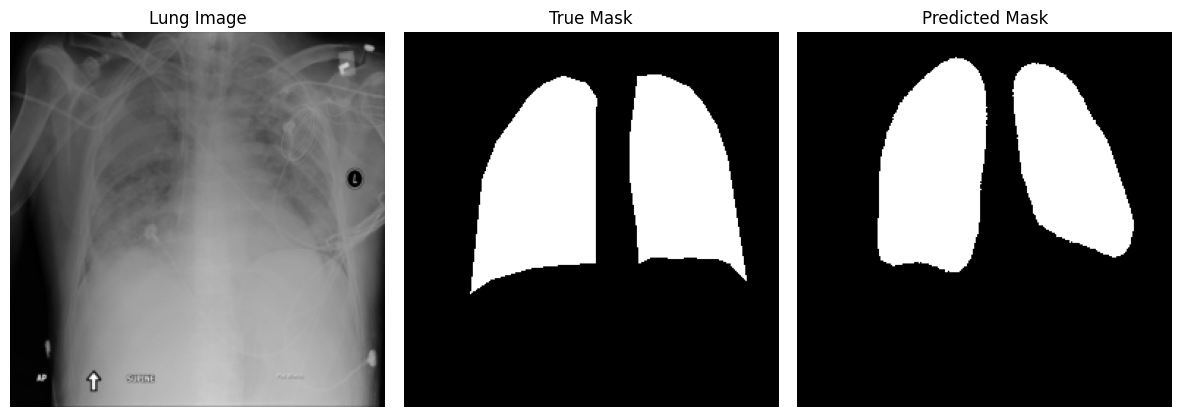

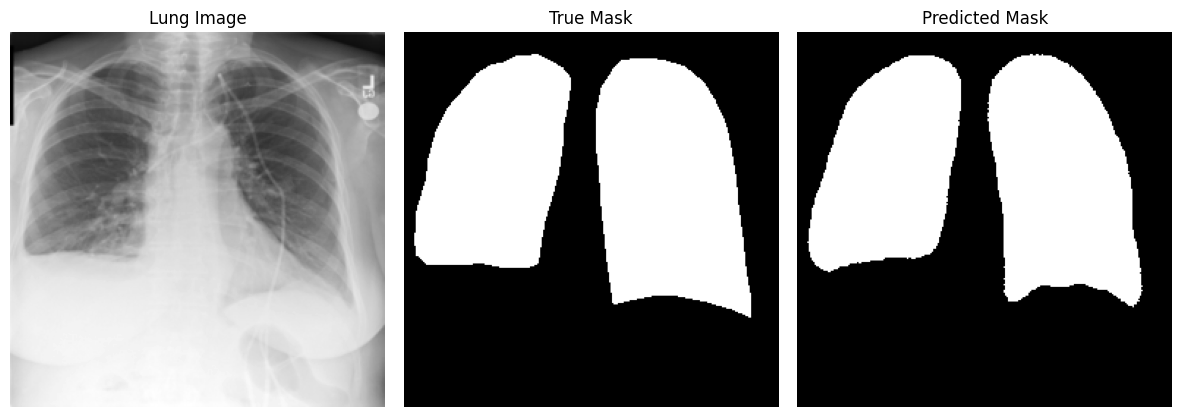

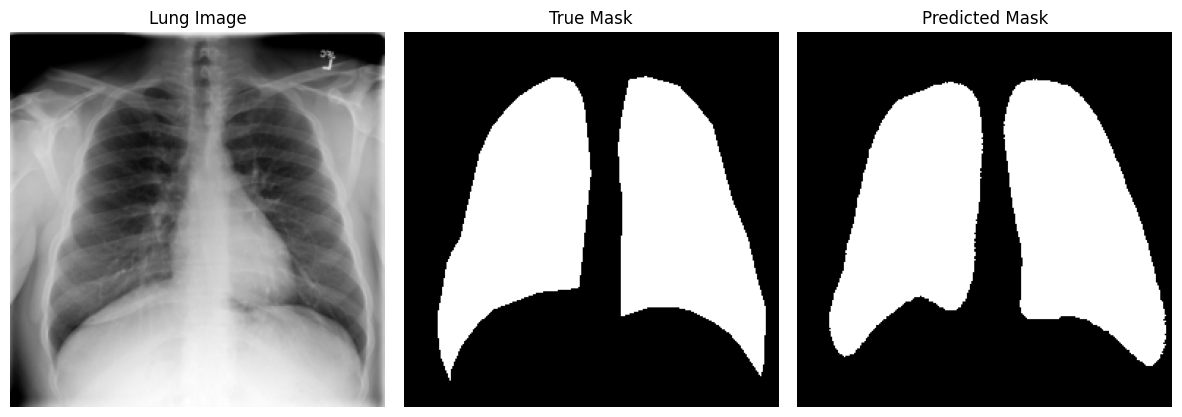

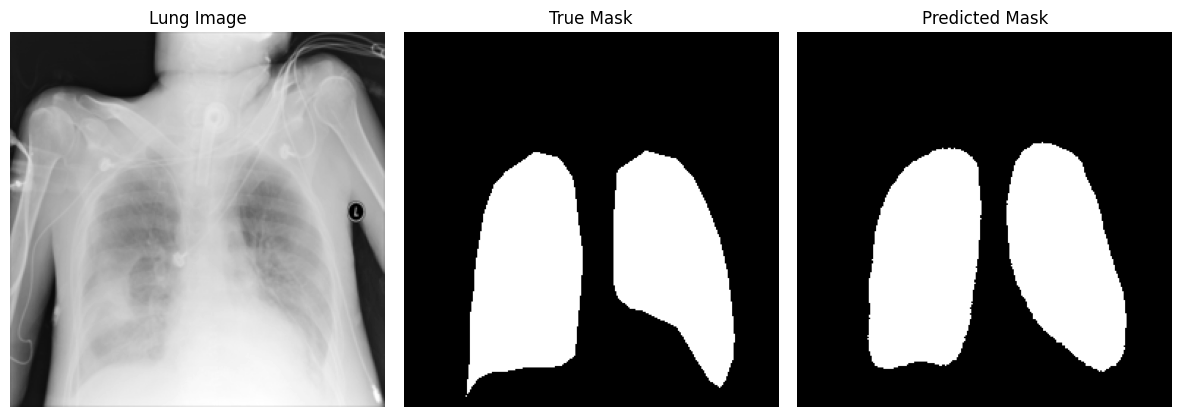

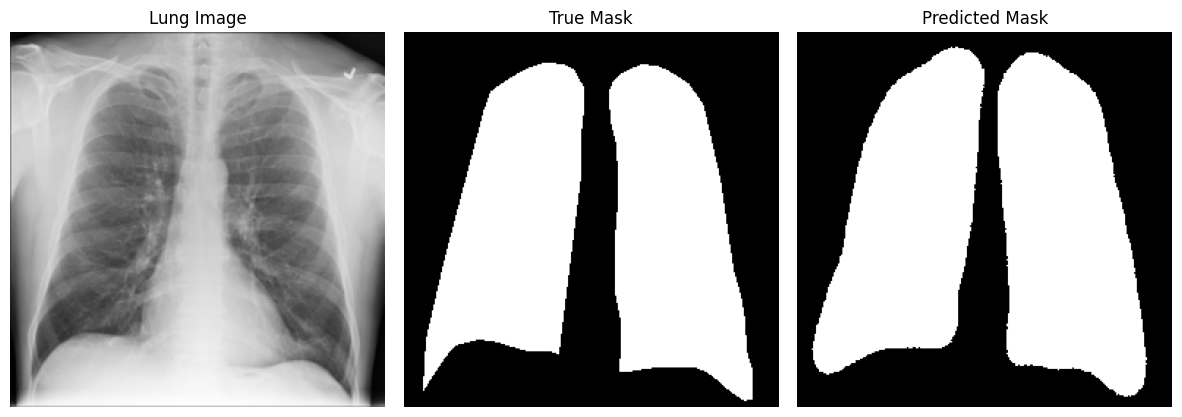

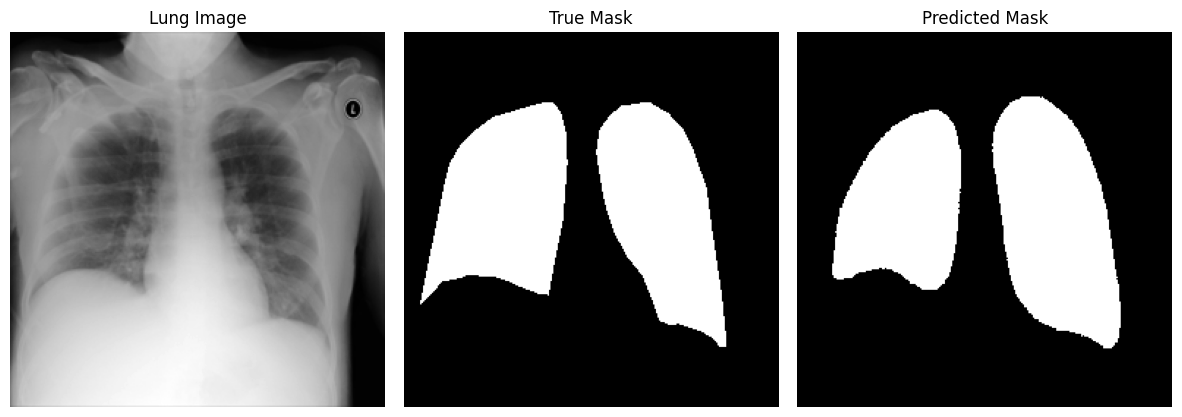

In [45]:
model.eval()

# Select 5 random samples from the test dataset
random.seed(0)
random_samples = random.sample(range(len(test_dataset)), 20)



for sample_idx in random_samples:
    # Get a test sample
    image, true_mask = test_dataset[sample_idx]
    image_unnormalized = image * std + mean

    # Predict the mask
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)  # Add batch dimension and move to the same device as the model
        predicted_mask = model(image)
        predicted_mask = predicted_mask.squeeze(0).squeeze(0).cpu()  # Remove batch and channel dimensions, and move to CPU

    # Binarize the predicted mask using the threshold
    threshold = 0.5
    predicted_mask = (predicted_mask > threshold).float()

    # Convert tensors to NumPy arrays for plotting
    lung_image = image_unnormalized.squeeze(0).numpy()
    true_mask = true_mask.squeeze(0).numpy()
    predicted_mask = predicted_mask.numpy()

    # Plot the lung image, true mask, and predicted mask
    plot_lung_and_masks(lung_image, true_mask, predicted_mask)

# 4. Your IoU score should be higher than 0.8

In [39]:
iou_score, dice_score = evaluate_model(model, test_loader)
print(f"IoU Score: {iou_score:.4f} , Dice Score : {dice_score:.4f}")

IoU Score: 0.8484 , Dice Score : 0.9164


# 5. Write a 2-page report using LaTex and upload your paper to ResearchGate or Arxiv, and put your paper link here.

https://www.researchgate.net/publication/370520890_Enhanced_Pulmonary_Segmentation_Employing_Encoder-Decoder_Architecture_using_ResNet101_as_Encoder

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file, and add paper link)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

(6). Discussion - 10 points

# References

- How to Use a Pretrained ResNet Model in PyTorch : https://reason.town/resnet-pretrained-model-pytorch/

- Datasets & DataLoaders : https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

- Concatenating datasets : https://www.oreilly.com/library/view/deep-learning-with/9781789534092/5f2cf6d8-4cdf-4e83-8c5b-58fbf722f6b6.xhtml

- Performing Image Augmentation using Pytorch : https://datamahadev.com/performing-image-augmentation-using-pytorch/

- PyTorch: How do the means and stds get calculated in the Transfer Learning tutorial? : https://stackoverflow.com/questions/48818619/pytorch-how-do-the-means-and-stds-get-calculated-in-the-transfer-learning-tutor

- Normalize images with transform in pytorch dataloader : https://xydida.com/2022/9/11/ComputerVision/Normalize-images-with-transform-in-pytorch-dataloader/

- Tuning Adam Optimizer Parameters in PyTorch : https://www.kdnuggets.com/2022/12/tuning-adam-optimizer-parameters-pytorch.html

- Intersection over Union (IoU) in Object Detection & Segmentation : https://learnopencv.com/intersection-over-union-iou-in-object-detection-and-segmentation/